In [7]:
import numpy as np
import scipy.linalg as alg
import matplotlib.pyplot as plt

Definindo os parâmetros

In [8]:
runs = 5000             # Npumero de eventos para calcular as CDFs
s = 1                   # Número de PUs transmitindo
m = 5                   # Número de SUs
n = 80                  # Número de amostras por SU
SNR = -10               # Relação sinal-ruído média em todos os SUs
rhoP = 0.0              # Fração das variações da potência do sinal em relação à média
rhoN = 0.0              # Fração das variações da potência do ruído em relação à média
meanK = 1.88            # Média do fator Rice (dB) para a variável K
sdK = 4.13              # Desvio padrão (dB) de K
randK = 1               # Se randK = 1, K é aleatório; se randK = 0, K = médiaK
Sigma2avg = 1           # Potência média de ruído
Npt = 50                # Número de pontos nos ROCs

Pré Monte Carlo (preparação)

In [9]:
# Potência média recebida
PRxavg = Sigma2avg*pow(10, SNR/10)

# Source powers
Ptx = np.ones((s, 1))*PRxavg/s

Tglrt_h0 = np.array([])
Tglrt_h1 = np.array([])

Execução do Monte Carlo

In [10]:
for i in range(0, runs):
    # PU signal (sxn):
    S = np.random.normal(0, 1/np.sqrt(2), (s, n)) + 1j*np.random.normal(0, 1/np.sqrt(2), (s, n))
    S = np.diag(np.sqrt(Ptx)) * S

    # Variações de ruído (m x 1) variáveis ​​em todas as rodadas de detecção
    Sigma2 = np.random.uniform(0, 1, (m, 1))*(2*rhoN)+(1-rhoN)
    Sigma2 = (Sigma2/np.mean(Sigma2))*Sigma2avg

    # Potências recebidas (m x 1) variáveis ​​em todas as rodadas de detecção
    PRx = np.random.uniform(0, 1, (m, 1))*(2*rhoP)+(1-rhoP)
    PRx = PRx/np.mean(PRx)*PRxavg

    # Channel matrix (mxs):
    G = np.ravel(np.sqrt(PRx/PRxavg))
    H = np.zeros((m, s), dtype='complex_')
    for row in range(0, m):
        for col in range(0, s):
            if randK == 1:
                K = pow(10, (np.random.normal(1, 1)*sdK+meanK)/10)               # Variable K
            else:
                K = pow(10, meanK/10)                                            # Fixed K
            H[row, col] = G[row]*(np.random.normal(np.sqrt(K/(2*(K+1))), np.sqrt((1-K/(K+1))/2)) + 1j*np.random.normal(np.sqrt(K/(2*(K+1))), np.sqrt((1-K/(K+1))/2)))

    # Matrizes de ruído gaussianas (mxn)
    W0 = np.zeros((m, n), dtype='complex_')
    W1 = np.zeros((m, n), dtype='complex_')
    for j in range(0, m):
        W0[j, :] = np.random.normal(0, np.sqrt(Sigma2[j]/2), (1, n)) + 1j*np.random.normal(0, np.sqrt(Sigma2[j]/2), (1, n))
        W1[j, :] = np.random.normal(0, np.sqrt(Sigma2[j]/2), (1, n)) + 1j*np.random.normal(0, np.sqrt(Sigma2[j]/2), (1, n))

    # Matrizes de sinal em H0 e H1 (mxn)
    X_h0 = W0
    X_h1 = np.matmul(H, S) + W1

    # Matrizes de covariância de amostra de sinal recebido (SCMs)
    R_h0 = np.matmul(X_h0, np.transpose(np.conjugate(X_h0)))/n
    R_h1 = np.matmul(X_h1, np.transpose(np.conjugate(X_h1)))/n

    # Autovalores dos SCMs
    lambda_h0 = np.abs(np.sort(np.linalg.eig(R_h0)[0]))
    lambda_h1 = np.abs(np.sort(np.linalg.eig(R_h1)[0]))

    # Estatística GLRT (teste de razão de verossimilhança generalizada)
    Tglrt_h0 = np.append(Tglrt_h0, lambda_h0[m-1]/((1/m)*np.trace(R_h0)))
    Tglrt_h1 = np.append(Tglrt_h1, lambda_h1[m-1]/((1/m)*np.trace(R_h1)))

Calculando as CDFs

In [11]:
CDF_Tglrt_H0 = np.array([])
CDF_Tglrt_H1 = np.array([])
# CDF - GLRT (teste de razão de verossimilhança generalizada)
T_h0 = Tglrt_h0
T_h1 = Tglrt_h1
Min = np.mean(T_h0)-3*np.std(T_h0)
Max = np.mean(T_h1)+3*np.std(T_h1)
i = Min
while i <= Max:
    aux_h0 = 0
    aux_h1 = 0
    for ii in range(0, runs):
        if T_h0[ii] < i:
            aux_h0 = aux_h0+1
        if T_h1[ii] < i:
            aux_h1 = aux_h1+1
    CDF_Tglrt_H0 = np.append(CDF_Tglrt_H0, aux_h0/runs)
    CDF_Tglrt_H1 = np.append(CDF_Tglrt_H1, aux_h1/runs)
    i += (Max-Min)/(Npt-1)

Plotando a curva ROC de resultado

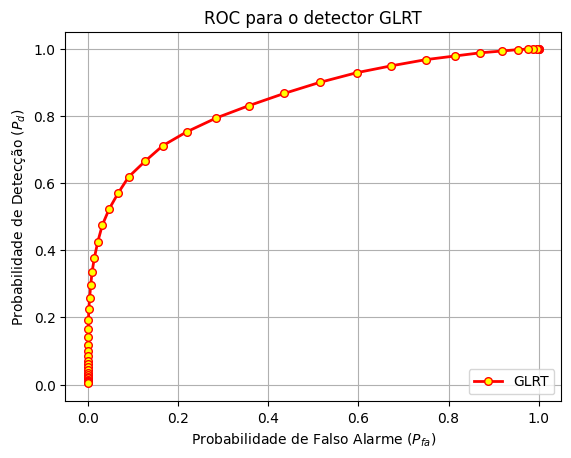

In [12]:
plt.plot(1-CDF_Tglrt_H0, 1-CDF_Tglrt_H1, color='red', linestyle='-', linewidth=2, marker='o', markersize=5.5, markerfacecolor='yellow', label='GLRT')
plt.title("ROC para o detector GLRT")
plt.ylabel("Probabilidade de Detecção ($P_{d}$)")
plt.xlabel("Probabilidade de Falso Alarme ($P_{fa}$)")
plt.legend(loc='lower right')
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xticks(np.arange(0, 1.1, 0.2))
plt.grid()
plt.savefig('ROC_GLRT.png', dpi=700)
plt.show()